In [100]:
import numpy as np

from tqdm import trange
from time import time
import os

import imageio
# import imageio.v2 as imageio
import matplotlib.pyplot as plt

from collections.abc import Iterable

In [2]:
data_path = "/home/v_trofinov/ice_data/"

radar_data = np.load(f'{data_path}/radars_2020-11-01_2022-12-31.npy')
# glorys     = np.load(f'{data_path}/glorys_2020-11-01_2022-12-31.npy')
# gfs = np.load(f'{data_path}/gfs_2020-11-01_2022-12-31.npy')

print('radar data : ', radar_data.shape)
# print('glorys data :', glorys.shape)
# print('gfs data :', gfs.shape)

radar data :  (791, 825, 200)


In [3]:
def load_mask_bin(mask_path):
    mask = imageio.v3.imread(mask_path)[:, :, 0]
    mask_bin = np.where(mask < 150, 1, 0)                  # make mask binary
    mask_neg = np.where(mask < 150, 1, -2)                 # make mask binary
    return mask_bin, mask_neg

def sea_idx(mask: np.array):
    I, J = np.where(mask != 0)
    return I, J

def norm_radar(radar_data: np.array, mask: np.array, eps=1e-7):
    norm_radar = radar_data.copy()
    norm_radar[norm_radar < 1e-5] = 0                  # mask gaps in data
    norm_radar = norm_radar * np.expand_dims(mask, 0)  # mask earth
    
    nonzero_data = norm_radar[(norm_radar != 0)]
    m = nonzero_data.mean(0)
    std = nonzero_data.std(0) + eps
    
    norm_radar = (norm_radar - m) / std
    norm_radar = norm_radar * np.expand_dims(mask, 0)
    norm_radar[norm_radar < -2.] = -2.
    return norm_radar, m, std

def fill_gaps_dummy(processed_data: np.array, mask: np.array):
    all_radar = processed_data.copy()
    for i in trange(1, len(all_radar)):
        one_radar = all_radar[i, :, :]
        I, J = np.where(one_radar == -2)
        
        if len(I) != 0:
            all_radar[i, I, J] = all_radar[i-1, I, J]
    return all_radar

In [4]:
mask, mask_neg = load_mask_bin(data_path + '/mask.png')
I, J = sea_idx(mask)

radar_data = np.load(f'{data_path}/radars_2020-11-01_2022-12-31.npy')
norm_data, _, _ = norm_radar(radar_data, mask)
norm_data = fill_gaps_dummy(norm_data, mask)

100%|████████████████████████████████████████████████████████████████████████████████| 790/790 [00:00<00:00, 811.19it/s]


In [5]:
def delete_rubish(radar: np.array):
    cleaned_data = radar.copy()
    deleted_ids = np.array([], dtype=int)
    saved_ids = np.arange(len(cleaned_data))
    
    for i in trange(1, len(cleaned_data)):
        diff = cleaned_data[i, :, :] - cleaned_data[i-1, :, :]       
        if diff.min() == diff.max():
            deleted_ids = np.append(deleted_ids, i)
            
    print(deleted_ids.shape[0] * 100 / len(cleaned_data), '%')
    cleaned_data = np.delete(cleaned_data, deleted_ids, 0)
    saved_ids = np.delete(saved_ids, deleted_ids)
    
    days_delta = np.diff(saved_ids)
    days_delta = np.append(days_delta, 0)   # pad last id with zero
    return cleaned_data, days_delta, saved_ids, deleted_ids

def slice_consistent_timedeltas(time_deltas: np.array, hist: int=None, thr=10):
    I = np.where(time_deltas >= thr)[0]
    low, high = 0, len(time_deltas)
    consistent_time_deltas = np.arange(high)
    
    del_ids = np.hstack([np.arange(i-hist, i+hist+1) for i in I])
    del_ids = np.clip(del_ids, low, high)
    consistent_time_deltas = np.delete(consistent_time_deltas, del_ids)
    return consistent_time_deltas

In [6]:
cleaned_radar, days_delta, _, _ = delete_rubish(norm_data)

100%|███████████████████████████████████████████████████████████████████████████████| 790/790 [00:00<00:00, 2908.19it/s]


67.63590391908976 %


In [7]:
days_delta

array([  3,   3,   2,   1,   1,   1,   1,   1,   2,   5,   1,   1,   5,
         3,   2,   1,   1,   1,   1,   1,   2,   3,   2,   1,   1,   1,
         4,   3,   3,   1,   1,   1,   3,   3,   2,   1,   1,   1,   1,
         1,   2,   6,   1,   3,   2,   3,   2,   1,   1,   3,   2,   6,
         1,   3,   2,   5,   1,   1,   1,   4,   3,   2,   1,   1,   1,
         2,   2,   3,   2,   1,   1,   3,   2,   3,   2,   1,   1,   1,
         1,   1,   2,   3,   2,   2,   5,   3,   2,   1,   1,   5,   3,
         2,   1,   1,   1,   1,   3,   3,   2,   1,   1,   5,   3,   2,
       116,   2,   2,   1,   1,   1,   1,   1,   2,   3,   2,   1,   1,
         3,   2,   5,   1,   1,   1,   2,   2,   3,   2,   2,   1,   1,
         1,   2,   3,   5,   2,   2,   3,   2,   1,   1,   1,   2,   2,
         3,   2,   1,   1,   3,   2,   5,   1,   1,   5,   3,   2,   1,
         1,  10,   1,   1,   1,   4,   3,   3,   2,   2,   2,   2,   1,
         1,   1,   1,   1,   3,   2,   3,   2,   1,   1,   1,   

In [8]:
consistent_time_deltas = slice_consistent_timedeltas(days_delta, 3)

cleaned_days_delta = days_delta[consistent_time_deltas]
cleaned_radar_by_time = cleaned_radar[consistent_time_deltas]

cleaned_days_delta

array([3, 3, 2, 1, 1, 1, 1, 1, 2, 5, 1, 1, 5, 3, 2, 1, 1, 1, 1, 1, 2, 3,
       2, 1, 1, 1, 4, 3, 3, 1, 1, 1, 3, 3, 2, 1, 1, 1, 1, 1, 2, 6, 1, 3,
       2, 3, 2, 1, 1, 3, 2, 6, 1, 3, 2, 5, 1, 1, 1, 4, 3, 2, 1, 1, 1, 2,
       2, 3, 2, 1, 1, 3, 2, 3, 2, 1, 1, 1, 1, 1, 2, 3, 2, 2, 5, 3, 2, 1,
       1, 5, 3, 2, 1, 1, 1, 1, 3, 3, 2, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1, 1,
       3, 2, 5, 1, 1, 1, 2, 2, 3, 2, 2, 1, 1, 1, 2, 3, 5, 2, 2, 3, 2, 1,
       1, 1, 2, 2, 3, 2, 1, 1, 3, 2, 5, 1, 1, 5, 3, 4, 3, 3, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 3, 2, 3, 2, 1, 1, 1, 2, 2, 5, 1, 1, 1, 4, 5, 5, 2,
       5, 2, 3, 2, 2, 2, 2, 3, 2, 5, 2, 2, 1, 2, 2, 2, 3, 2, 1, 1, 1, 1,
       1, 2, 3, 2, 2, 1, 1, 1, 2, 3, 2, 1, 1, 1, 1, 1, 2, 6, 1, 1, 1, 9,
       1, 0])

In [9]:
def make_time_tensor(days_delta: np.array, shape_cleaned_radar: Iterable, max_days=10):
    time_tensor = np.zeros(shape_cleaned_radar)
    for i in range(shape_cleaned_radar[0]):
        time_tensor[i, :, :] = days_delta[i]
    time_tensor = time_tensor / max_days
    return time_tensor

In [10]:
def make_hist_split(data: np.array,
                    time_intervals: np.array,
                    hist_len: int,
                    I: np.array,
                    J: np.array,
                    predict_horizon=1,
                    known_pred_horiz=False):
    
    hist_delta = hist_len + predict_horizon
    limit = data.shape[0] - hist_delta
    sample_num = limit * len(I)
    processed_data_time = np.zeros([sample_num, hist_delta * 2 + 1], dtype=np.float32)
    
    for i in trange(hist_delta):
        end_bound = limit + i
        processed_data_time[:, i] = time_intervals[i:end_bound, I, J].reshape(-1)
        processed_data_time[:, 1+hist_delta+i] = data[i:end_bound, I, J].reshape(-1)
    
    if type(known_pred_horiz) is np.array:
        processed_data_time[:, hist_delta+1] = known_pred_horiz
    else:
        processed_data_time[:, hist_delta+1] = processed_data_time[:, hist_len-1:-1].sum(axis=1)
    
    feat_ids = np.hstack([
        np.arange(hist_len),
        np.arange(hist_delta-1, hist_delta+hist_len),
    ])
    X, y = processed_data_time[:, feat_ids], processed_data_time[:, -1]
    return X, y
    
def train_test_split(radar: np.array, split: Iterable):
    assert (np.sum(split) == 1) & (len(split) in {2, 3})
    
    l = len(radar)
    train_pairs = radar[:int(l * split[0]), :, :]
    if len(split) == 3:
        valid_pairs = radar[int(l * split[0]):int(l * split[1]), :, :]
    test_pairs = radar[int(l * split[-1]):, :, :]
    
    if len(split) == 3:
        return train_pairs, valid_pairs, test_pairs
    else:
        return train_pairs, test_pairs

In [11]:
days_delta_tensor = make_time_tensor(cleaned_days_delta, cleaned_radar_by_time.shape)

In [12]:
train_radar, test_radar = train_test_split(cleaned_radar_by_time, [.7, .3])
train_time, test_time = train_test_split(days_delta_tensor, [.7, .3])

train_X, train_y = make_hist_split(train_radar, train_time, hist_len=5,
                                   I=I, J=J, predict_horizon=1)
test_X, test_y = make_hist_split(test_radar, test_time, hist_len=5,
                                 I=I, J=J, predict_horizon=1)

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.62it/s]


----

In [13]:
# train_X = train_X[:, -3:]
# test_X = test_X[:, -3:]

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg_model = LinearRegression(n_jobs=-1)
lin_reg_model.fit(train_X, train_y)

train_y_hat = lin_reg_model.predict(train_X)
test_y_hat = lin_reg_model.predict(test_X)

In [15]:
train_rmse = mean_squared_error(train_y, train_y_hat, squared=False)
test_rmse = mean_squared_error(test_y, test_y_hat, squared=False)

display(train_rmse, test_rmse)

0.5091527

0.5266788

In [16]:
test_y_hat.shape[0] / len(I)

150.0

In [17]:
lin_reg_model.coef_

array([-1.3158230e-01, -1.6420715e-02,  5.8241084e-02,  1.3013181e-01,
       -2.1714017e-01, -3.0104968e-01, -2.9802322e-08,  3.7327915e-01,
       -5.2763051e-01, -3.1705743e-01, -9.7082034e-02], dtype=float32)

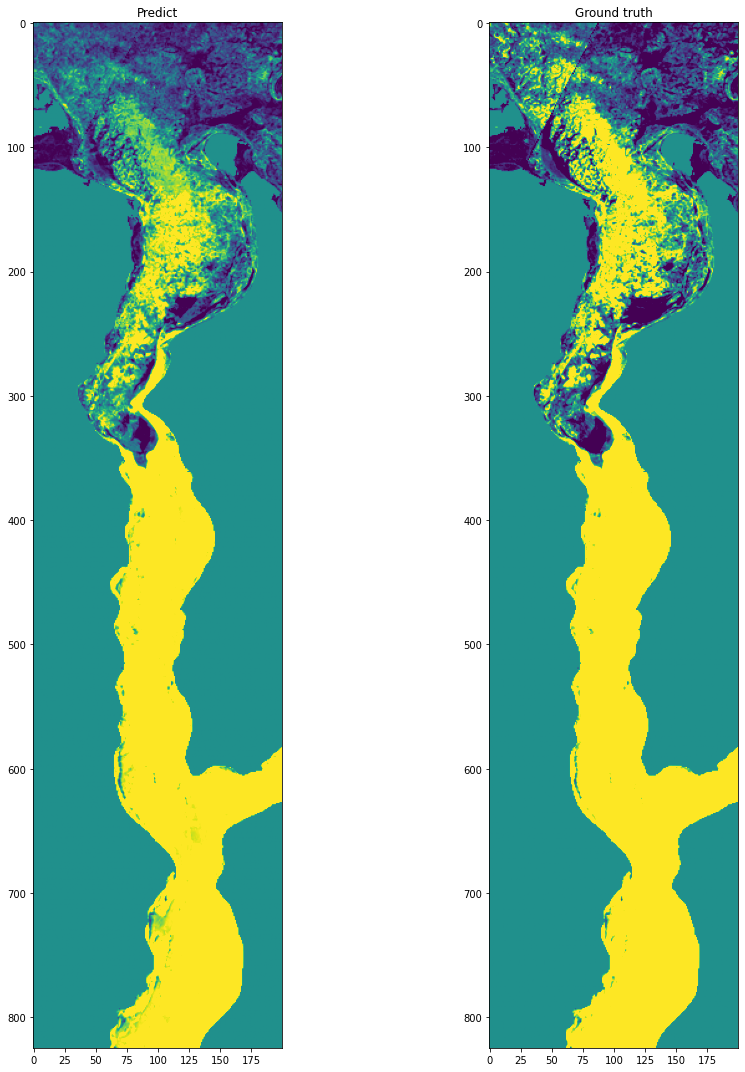

In [18]:
i = 140
snapshot_hat = np.zeros([825, 200])
snapshot_hat[I, J] = train_y_hat[i*len(I):(i+1)*len(I)]

snapshot = np.zeros([825, 200])
snapshot[I, J] = train_y[i*len(I):(i+1)*len(I)]

_, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(snapshot_hat, vmin=-1, vmax=1)
axes[0].set_title('Predict')

axes[1].imshow(snapshot, vmin=-1, vmax=1)
axes[1].set_title('Ground truth')
plt.tight_layout()

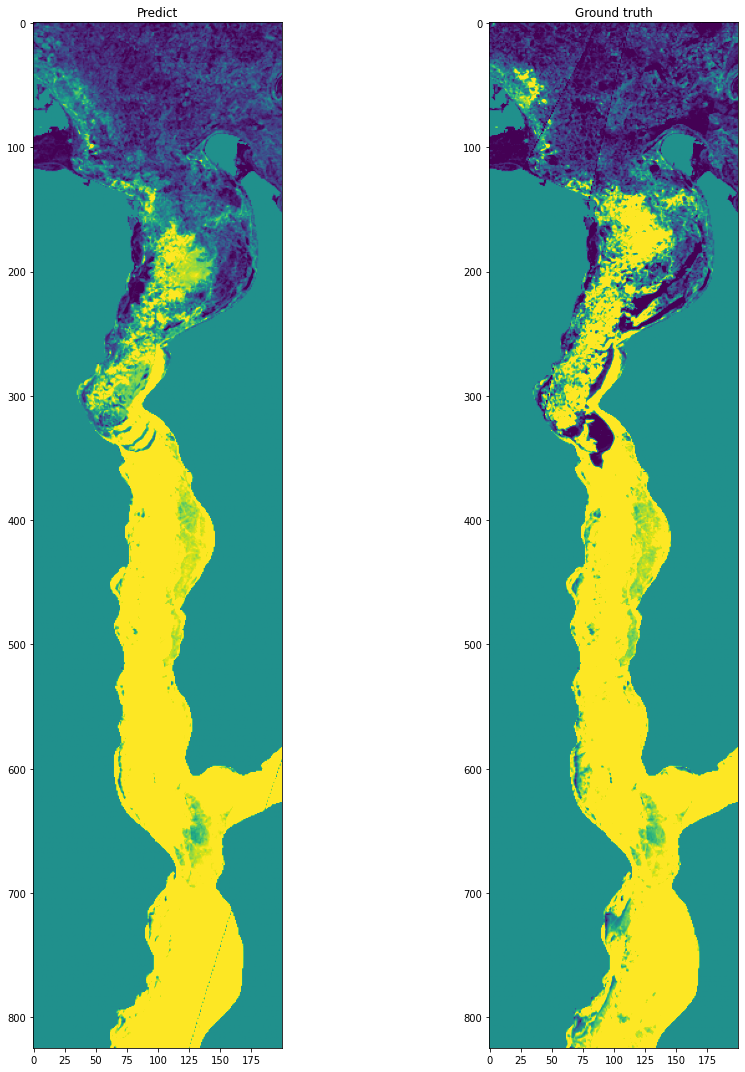

In [19]:
i = 69
snapshot_hat = np.zeros([825, 200])
snapshot_hat[I, J] = test_y_hat[i*len(I):(i+1)*len(I)]

snapshot = np.zeros([825, 200])
snapshot[I, J] = test_y[i*len(I):(i+1)*len(I)]

_, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(snapshot_hat, vmin=-1, vmax=1)
axes[0].set_title('Predict')

axes[1].imshow(snapshot, vmin=-1, vmax=1)
axes[1].set_title('Ground truth')
plt.tight_layout()

In [21]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(random_seed=42)
cat.fit(train_X, train_y)
cat_y_train_hat = cat.predict(train_X)
cat_y_test_hat = cat.predict(test_X)

Learning rate set to 0.177687
0:	learn: 0.8886338	total: 475ms	remaining: 7m 54s
1:	learn: 0.7926530	total: 896ms	remaining: 7m 26s
2:	learn: 0.7198169	total: 1.28s	remaining: 7m 6s
3:	learn: 0.6653145	total: 1.65s	remaining: 6m 49s
4:	learn: 0.6247803	total: 2.02s	remaining: 6m 42s
5:	learn: 0.5942524	total: 2.4s	remaining: 6m 37s
6:	learn: 0.5724749	total: 2.75s	remaining: 6m 29s
7:	learn: 0.5559259	total: 3.14s	remaining: 6m 28s
8:	learn: 0.5440504	total: 3.52s	remaining: 6m 27s
9:	learn: 0.5351753	total: 3.93s	remaining: 6m 28s
10:	learn: 0.5289618	total: 4.32s	remaining: 6m 28s
11:	learn: 0.5239289	total: 4.7s	remaining: 6m 26s
12:	learn: 0.5200814	total: 5.07s	remaining: 6m 25s
13:	learn: 0.5170087	total: 5.46s	remaining: 6m 24s
14:	learn: 0.5145452	total: 5.79s	remaining: 6m 19s
15:	learn: 0.5122856	total: 6.12s	remaining: 6m 16s
16:	learn: 0.5104134	total: 6.47s	remaining: 6m 14s
17:	learn: 0.5081470	total: 6.83s	remaining: 6m 12s
18:	learn: 0.5068768	total: 7.13s	remaining: 6m

In [22]:
cat_train_rmse = mean_squared_error(train_y, cat_y_train_hat, squared=False)
cat_test_rmse = mean_squared_error(test_y, cat_y_test_hat, squared=False)

display(cat_train_rmse, cat_test_rmse)

0.4244385161400773

0.47439556875475236

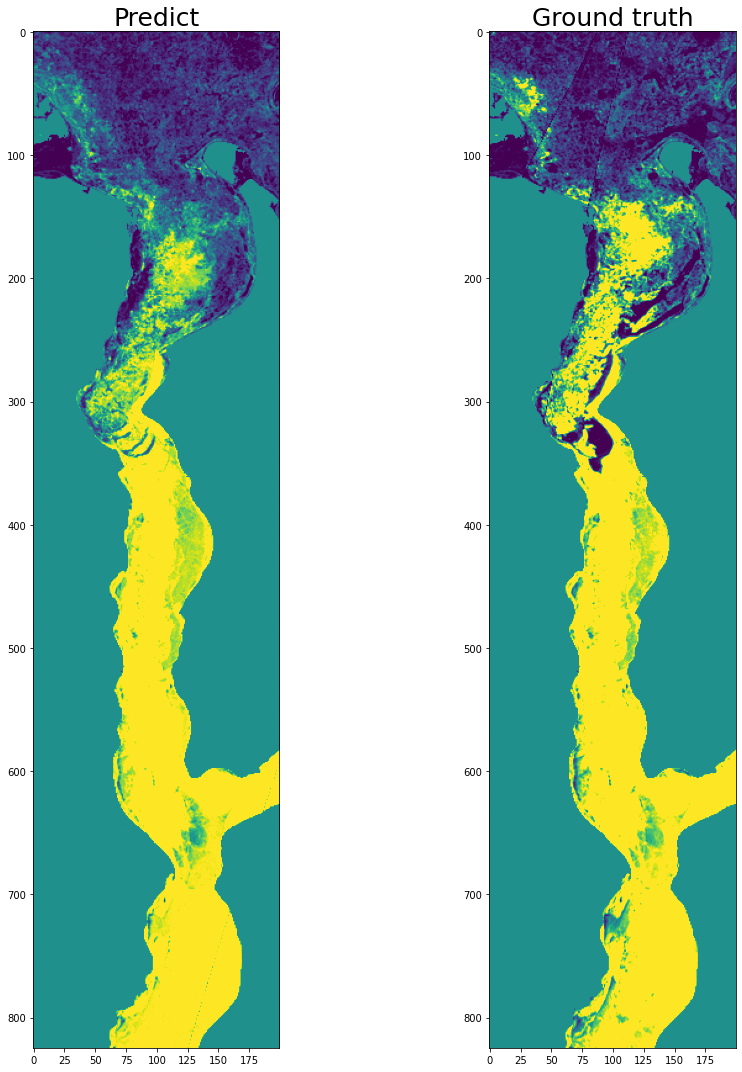

In [23]:
i = 69
snapshot_hat = np.zeros([825, 200])
snapshot_hat[I, J] = cat_y_test_hat[i*len(I):(i+1)*len(I)]

snapshot = np.zeros([825, 200])
snapshot[I, J] = test_y[i*len(I):(i+1)*len(I)]

_, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(snapshot_hat, vmin=-1, vmax=1)
axes[0].set_title('Predict', fontsize=25)

axes[1].imshow(snapshot, vmin=-1, vmax=1)
axes[1].set_title('Ground truth', fontsize=25)
plt.tight_layout()

In [122]:
def make_gif(y_true: np.array, y_pred: np.array,
            I: np.array, J: np.array,
            out_name: str, frame_per_pic=3):
    filenames = []
    delim = y_true.shape[0] // (825 * 200)
    
    if not os.path.isdir('/home/v_trofinov/Data-driven_ice_tracking/pics/'):
        os.mkdir('/home/v_trofinov/Data-driven_ice_tracking/pics/')
    
    for i in trange(delim):
        snapshot = np.zeros([825, 200])
        snapshot[I, J] = y_true[i*len(I):(i+1)*len(I)]

        snapshot_hat = np.zeros([825, 200])
        snapshot_hat[I, J] = y_pred[i*len(I):(i+1)*len(I)]
        
        _, axes = plt.subplots(1, 2, figsize=(15, 15))
        axes[0].imshow(snapshot_hat, vmin=-1, vmax=1)
        axes[0].set_title('Predict', fontsize=25)
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].imshow(snapshot, vmin=-1, vmax=1)
        axes[1].set_title('Ground truth', fontsize=25)
        axes[1].set_xticks([])
        axes[1].set_yticks([])
        plt.tight_layout()
        
        filename = f'./pics/file{i}.png'
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()
    
    with imageio.get_writer(out_name+'.gif', mode='I', duration=800) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Remove files
    for filename in set(filenames):
        os.remove(filename)
    return

In [123]:
make_gif(test_y, test_y_hat, I, J, 'lin_reg_test_hist5_horiz1_time')
make_gif(test_y, cat_y_test_hat, I, J, 'cat_test_hist5_horiz1_time')

100%|███████████████████████████████████████████████████████████████████████████████████| 66/66 [00:19<00:00,  3.42it/s]
/tmp/ipykernel_28216/1068414300.py:39: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
100%|███████████████████████████████████████████████████████████████████████████████████| 66/66 [00:18<00:00,  3.51it/s]
